## Mision Impossible: Ghost protocol
Synthesizing optical illusion using homography transformations

In [1]:
import numpy as np
from PIL import Image, ImageDraw
import cv2

### 3D scene elements
constances:
    -coridor length L in meters
    - coridor width W
    - coridor height H
    - doors comes in every 5 meters
    - light in the center on every 3rd panel
    
ceiling - panels 1 x 1 meter

floor - squares 0.5 x 0.5 meter - chess board

global ref frame: y - goes along with coridor, z - goes up, the origin is in the left corner

from the guard. The guard is at the coridor center.

In [2]:
floor_light = (112,128,144)  # slategrey
floor_dark = (128, 128, 128) # grey
walls_col = (200,190,160) # tan
wall_dark_col = (190, 165, 135)
ceiling_col = (190, 175, 165) # lightgrey
light_col = (255, 255, 240) # ivory
doors_col = (139,69,19) # sadlebrown
darkbrown = (100, 60, 15)
grey = (128, 128, 128)
whitesmoke = (220, 220, 205)

COR_W = 4
COR_H = 3
COR_L = 35
DOOR_H = 2.1


def init_poligons(guard, cor_L=COR_L, cor_W=COR_W, cor_H=COR_H):
    the_wall = [(np.array([cor_W/2+0.5, cor_L, cor_H/2]),
               [np.array([0, cor_L, 0]), np.array([0, cor_L, cor_H]), np.array([cor_W + 1, cor_L, cor_H]), 
                np.array([cor_W + 1, cor_L, 0]), np.array([0, cor_L, 0])], wall_dark_col, None)]
    
    floor = [ (np.array([i * 0.5 + 0.25, j * 0.5 + 0.25, 0]),
               [np.array([i * 0.5, j * 0.5, 0]), np.array([i * 0.5+0.5, j * 0.5, 0]), np.array([i * 0.5 + 0.5, j * 0.5 + 0.5, 0]), 
                np.array([i * 0.5, j * 0.5 + 0.5, 0]), np.array([i * 0.5, j * 0.5, 0])], floor_light if (i+j)%2==0 else floor_dark, None) 
             for i in range(cor_W * 2) for j in range(cor_L * 2)] +\
    [(np.array([cor_W + 0.25, j * 0.5 + 0.25, 0]),
               [np.array([cor_W, j * 0.5, 0]), np.array([cor_W + 0.5, j * 0.5, 0]), np.array([cor_W + 0.5, j * 0.5 + 0.5, 0]), 
                np.array([cor_W, j * 0.5 + 0.5, 0]), np.array([cor_W, j * 0.5, 0])], floor_light if (2*cor_W+j)%2==0 else floor_dark, None)
            for j in range(2*(cor_L - cor_W), 2*cor_L)]
    
    ceiling = [ (np.array([i + 0.5, j + 0.5, cor_H]),
               [np.array([i, j, cor_H]), np.array([i + 1, j, cor_H]), np.array([i + 1, j + 1, cor_H]), 
                np.array([i, j + 1, cor_H]), np.array([i, j, cor_H])], light_col if (0 < i < cor_W-1) and j%5==0 and j < cor_L-2 else ceiling_col, grey)
                for i in range(cor_W) for j in range(cor_L)] +\
    [(np.array([cor_W + 0.5, j + 0.5, cor_H]),
               [np.array([cor_W, j, cor_H]), np.array([cor_W + 1, j, cor_H]), np.array([cor_W + 1, j + 1, cor_H]), 
                np.array([cor_W, j + 1, cor_H]), np.array([cor_W, j, cor_H])], ceiling_col, grey)
                for j in range(cor_L-cor_W, cor_L)]
    
    left_walls = [ (np.array([0, j + 0.5, cor_H/2]),
               [np.array([0, j, 0]), np.array([0, j, cor_H]), np.array([0, j + 1, cor_H]), 
                np.array([0, j + 1, 0]), np.array([0, j, 0])], walls_col, None)  
                for j in range(cor_L)]
    right_walls = [ (np.array([cor_W, j + 0.5, cor_H/2]),
               [np.array([cor_W, j, 0]), np.array([cor_W, j, cor_H]), np.array([cor_W, j + 1, cor_H]), 
                np.array([cor_W, j + 1, 0]), np.array([cor_W, j, 0])], walls_col, None)  
                for j in range(cor_L - cor_W)]
    
    left_doors = [(np.array([0.01, j + 0.45, DOOR_H/2]),
               [np.array([0.01, j, 0]), np.array([0.01, j, DOOR_H]), np.array([0.01, j + 0.9, DOOR_H]), 
                np.array([0.01, j + 0.9, 0]), np.array([0.01, j+0.9, 0]) ], doors_col, darkbrown)  
                for j in range(1, cor_L-2) if j % 5==0]
    
    right_doors = [(np.array([cor_W-0.01, j + 0.45, DOOR_H/2]),
               [np.array([cor_W-0.01, j, 0]), np.array([cor_W-0.01, j, DOOR_H]), np.array([cor_W-0.01, j + 0.9, DOOR_H]), 
                np.array([cor_W-0.01, j + 0.9, 0]), np.array([cor_W-0.01, j + 0.9, 0]) ], doors_col, darkbrown)  
                for j in range(1, cor_L - cor_W - 2) if j % 5==0]
    
    polygons = the_wall + floor + ceiling + left_walls + right_walls + left_doors + right_doors
    return sorted(polygons, key=lambda x: np.linalg.norm(x[0] - guard), reverse=True)

In [3]:
# guard coords in global RF
guard = (2.5, -0.001, 1.8)


In [4]:
# some polygons verification
polygons = init_poligons(guard=guard)
for c, pol, col, _ in polygons:
    if np.linalg.norm(np.array(pol[:-1]).mean(axis=0) - c ) > 0.01:
        print(c, pol, col)
        
print(len(polygons), "polygons")

790 polygons


In [5]:
# camera is always directed along Y-axis of global RF
def get_camera_matrix(loc, img_size, focal):
    px, py = np.array(img_size) / 2
    K = np.array([[focal, 0, px],
                 [0, focal, py],
                 [0,     0,  1]])

    T =  np.array(loc)
    R = np.array([[1, 0, 0],
                 [0, 0, 1],
                 [0, -1, 0]])
    RT = np.hstack([R.T, -np.array([R.T.dot(loc)]).T])
    return K.dot(RT)
    

In [6]:
def get_point_proj_on_screen(x, z, Ls, guard):
    # finds projection on screen of a point (x, Lw, z)
    # screen is at Ls distance from the guard
#     print(screen_px_per_meter)
    xg, _, zg = guard
    px = xg + Ls * (x - xg) / COR_L
    py = COR_H - zg - Ls * (z - zg) / COR_L
    return np.array([px, py]) 

In [7]:
def get_homo_coeffs(pts_dst, pts_src):
    h, status = cv2.findHomography(pts_dst, pts_src)
    
    return np.reshape(h, (9,))[:-1]

In [8]:
def assemble_image(im_src, src_polygons, dst_polygons, screen_size):
    dst_img = Image.new('RGBA', tuple(screen_size), color=whitesmoke)
    for src, dst in zip(src_polygons, dst_polygons):
        coeffs = get_homo_coeffs(dst, src)
        img_dst = im_src.transform(tuple(screen_size), Image.PERSPECTIVE, coeffs, Image.BICUBIC)
#         display(img_dst)
        
        mask = Image.new('L', img_dst.size, color=255)
        draw = ImageDraw.Draw(mask)
        for poly in dst_polygons:
            if (poly == dst).all():
                continue
            # mask other parts od the image
            transparent_area = [ tuple(arr) for arr in poly ]
            draw.polygon(transparent_area, fill = 0)
            img_dst.putalpha(mask)
#         display(img_dst)
        dst_img.paste(img_dst, (0, 0), img_dst)

    return dst_img

In [9]:
def get_projected_image(guard, source_img, corners, screen_size, cm, distance_to_screen):
    uvw = cm.dot(corners)
    p5, p6, p7, p8 = (uvw[:2] / uvw[2]).T
#     print("src_img:", p5,p6,p7,p8)
    
    p1, p2 = np.array([0, screen_size[1]]),  np.array([0, 0])
    p3, p4 = np.array([screen_size[0], 0]), screen_size
    
    src_polygons = [
        np.array([p1, p2, p6, p5]), np.array([p2, p3, p7, p6]), np.array([p3, p4, p8, p7]),
        np.array([p4, p1, p5, p8]), np.array([p5, p6, p7, p8])
    ]
    
    ## destination
    p6 = get_point_proj_on_screen(0, COR_H, distance_to_screen, guard) * screen_size / np.array([COR_W, COR_H])
    p5 = get_point_proj_on_screen(0, 0, distance_to_screen, guard) * screen_size / np.array([COR_W, COR_H])
    p7 = get_point_proj_on_screen(COR_W, COR_H, distance_to_screen, guard) * screen_size / np.array([COR_W, COR_H])
    p8 = get_point_proj_on_screen(COR_W, 0, distance_to_screen, guard) * screen_size / np.array([COR_W, COR_H])
#     print(p5,p6,p7,p8)
    
    dst_polygons = [
        np.array([np.array([0, screen_size[1]]), np.array([0, 0]), p6, p5]),
        np.array([np.array([0, 0]), np.array([screen_size[0], 0]), p7, p6]),
        np.array([np.array([screen_size[0], 0]), screen_size, p8, p7]),
        np.array([screen_size, np.array([0, screen_size[1]]), p5, p8]),
        np.array([p5, p6, p7, p8])
    ]
    return assemble_image(source_img, src_polygons, dst_polygons, screen_size)
    


In [10]:
def get_camera_image(camera_loc, img_size, focal):
    cm = get_camera_matrix(camera_loc, img_size, focal)
    im = Image.new("RGB", img_size, (0,0,0))
    draw = ImageDraw.Draw(im)
    polys = polygons[:]
    polys = sorted(polys,  key=lambda x: np.linalg.norm(x[0] - guard), reverse=True)    
        
    for _,poly,color,stroke in polys:
        pixs = [cm.dot(np.hstack([p, 1])) for p in poly]
        if (np.array(pixs)[:, 2] > 0).all():
            draw.polygon([ (u/w, v/w) for u,v,w in pixs ], fill=color, outline=stroke)
    return im

In [11]:
def create_view(guard, dist_to_screen=None, project=False, img_size=(1200, 600), focal=800):
    guard_view = get_camera_image(guard, img_size, focal)
    
    if project and dist_to_screen:
        d = 0.001
        cam = (COR_W / 2, dist_to_screen - COR_W / 8, COR_H / 2)
        screen_size = (1600, 1200)
        cam_focal = 200
        source_img = get_camera_image(cam, screen_size, focal=cam_focal)
#         display(source_img)
        
        screen = [np.array([d, dist_to_screen, d]), np.array([d, dist_to_screen, COR_H - d]), 
                np.array([COR_W - d, dist_to_screen, COR_H - d]), np.array([COR_W - d, dist_to_screen, d]), 
                  np.array([d, dist_to_screen, d])]
        center = np.array(screen[:-1]).mean(axis=0)
        
        cm = get_camera_matrix(cam, screen_size, focal=cam_focal)
        pixs = [ cm.dot(np.hstack([p, 1])) for p in screen]
        proj_pixs = [ np.array([u/w, v/w]) for u,v,w in pixs ]
               
        wall = [np.array([0, COR_L, 0]), np.array([0, COR_L, COR_H]), np.array([COR_W, COR_L, COR_H]),
                np.array([COR_W, COR_L, 0]) ]
        corners = np.vstack([np.array(wall).T, np.ones((1,4))])    
        proj_img = get_projected_image(guard, source_img, corners, screen_size, cm, dist_to_screen)
#         display(proj_img)
#         print("proj_img size:", proj_img.size)
            
        guard_cam = get_camera_matrix(guard, img_size, focal=focal)
        pixs = [ guard_cam.dot(np.hstack([p, 1])) for p in screen]
        proj_pixs = [ np.array([u/w, v/w]) for u,v,w in pixs ]
        
        xy_min = np.array(proj_pixs).min(axis=0)
        xy_max = np.array(proj_pixs).max(axis=0)
        screen_size_on_guard_img = (xy_max - xy_min).astype('int')
        img = proj_img.resize(tuple(screen_size_on_guard_img), Image.ANTIALIAS)
#         print(np.array(img).shape)
        if np.random.random() > 0.07:
            guard_view.paste(img, tuple(xy_min.astype('int')), img)
        else:
            overlay = Image.new('RGBA', tuple(img_size), (0, 0, 0, 0))
            draw = ImageDraw.Draw(overlay)
            draw.rectangle([tuple(xy_min), tuple(xy_max)], fill=(100, 100, 100, 50), outline=whitesmoke, width=1)
            guard_view = Image.alpha_composite(guard_view.convert('RGBA'), overlay).convert('RGB')
        draw = ImageDraw.Draw(guard_view)    
        draw.rectangle([tuple(xy_min), tuple(xy_max)], fill=None, outline=(180, 180, 165), width=1)
    return guard_view

In [12]:
def concatenate(im1, im2):
    margin = 15
    dst = Image.new('RGB', (im1.width, margin + 2 * im1.height), (255, 255, 255))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, margin + im1.height))
    return dst

In [13]:
guard_positions = np.linspace((3, 0, 1.2), (2.8, 0, 1.75), 15)
guard_positions

array([[3.        , 0.        , 1.2       ],
       [2.98571429, 0.        , 1.23928571],
       [2.97142857, 0.        , 1.27857143],
       [2.95714286, 0.        , 1.31785714],
       [2.94285714, 0.        , 1.35714286],
       [2.92857143, 0.        , 1.39642857],
       [2.91428571, 0.        , 1.43571429],
       [2.9       , 0.        , 1.475     ],
       [2.88571429, 0.        , 1.51428571],
       [2.87142857, 0.        , 1.55357143],
       [2.85714286, 0.        , 1.59285714],
       [2.84285714, 0.        , 1.63214286],
       [2.82857143, 0.        , 1.67142857],
       [2.81428571, 0.        , 1.71071429],
       [2.8       , 0.        , 1.75      ]])

In [14]:
guard_positions = np.vstack([guard_positions, np.linspace((2.8, 0, 1.75), (1.5, 0, 1.75), 40)])
screen_positions = np.linspace(18, 12, len(guard_positions)).astype('int')

In [15]:
images = []
for guard_pos, screen_pos in zip(guard_positions, screen_positions):
    im1 = create_view(guard_pos, dist_to_screen=screen_pos, project=False, img_size=(600, 300), focal=600)
    im2 = create_view(guard_pos, dist_to_screen=screen_pos, project=True, img_size=(600, 300), focal=600)
    dst = concatenate(im1, im2)
    images.append(dst)


In [16]:
images[0].save('kremlin-hallway.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)

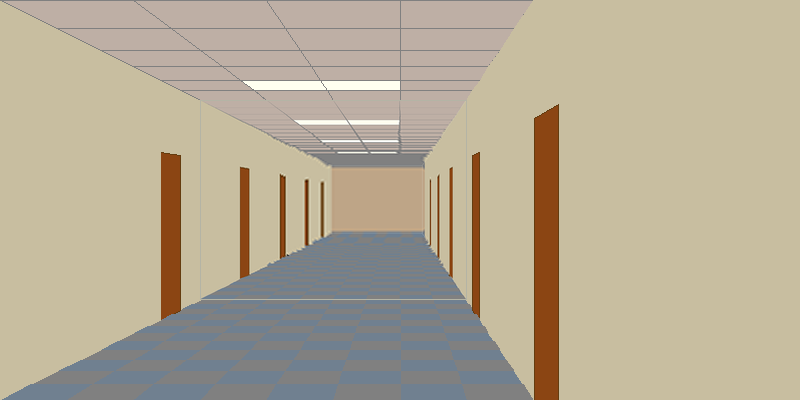

In [17]:
create_view((3,0,1.5), dist_to_screen=12, project=True, img_size=(800, 400), focal=800)